# Volatility basket strategy

- Same as from `30-vol-basket-arb-new` 
- Use Binance data for tokens as we get longer history

# Set up

Set up Trading Strategy data client.


In [31]:
import logging

from tradingstrategy.client import Client
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode

client = Client.create_jupyter_client()

# Set up drawing charts in interactive vector output mode.
# This is slower. See the alternative commented option below.
# setup_charting_and_output(OutputMode.interactive)

# Set up rendering static PNG images.
# This is much faster but disables zoom on any chart.
setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)


Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


# Parameters

- Collection of parameters used in the calculations

In [32]:
import datetime

import pandas as pd

from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.parameters import StrategyParameters


class Parameters:

    id = "31-vol-basket-arb-binance-data"

    # We trade 1h candle
    candle_time_bucket = TimeBucket.h1
    cycle_duration = CycleDuration.cycle_4h
    
    # Coingecko categories to include
    #
    # See list here: TODO
    #
    chain_id = ChainId.arbitrum
    
    #
    # Basket construction and rebalance parameters
    #
    min_asset_universe = 10  # How many assets we need in the asset universe to start running the index
    max_assets_in_portfolio = 3  # How many assets our basket can hold once
    allocation = 0.99  # Allocate all cash to volatile pairs
    min_rebalance_trade_threshold_pct = 0.10  # % of portfolio composition must change before triggering rebalacne
    individual_rebalance_min_threshold_usd = 10  # Don't make buys less than this amount
    min_volatility_threshold = 0.02  # Set to have Sharpe ratio threshold for the inclusion
    per_position_cap_of_pool = 0.02  # Never own more than % of the lit liquidity of the trading pool
    max_concentration = 0.40 # How large % can one asset be in a portfolio once
    min_signal_threshold = 0.01

    #
    # Inclusion criteria parameters:
    # - We set the length of various indicators used in the inclusion criteria
    # - We set minimum thresholds neede to be included in the index to filter out illiquid pairs
    #

    # For the length of trailing sharpe used in inclusion criteria
    trailing_sharpe_bars = pd.Timedelta("60d") // candle_time_bucket.to_timedelta()  # How many bars to use in trailing sharpe indicator
    rebalance_volalitity_bars = pd.Timedelta("14d") // candle_time_bucket.to_timedelta()  # How many bars to use in volatility indicator
    rolling_volume_bars = pd.Timedelta("14d") // candle_time_bucket.to_timedelta()
    rolling_liquidity_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    ewm_span = 400  # How many bars to use in exponential moving average for trailing sharpe smoothing
    min_volume = 1_000_000   # USD
    min_liquidity = 200_000  # USD
    min_token_sniffer_score = 30  # Scam filter
    
    #
    # Backtesting only
    #
    backtest_start = datetime.datetime(2022, 8, 15)
    backtest_end = datetime.datetime(2024, 10, 20)
    initial_cash = 10_000


parameters = StrategyParameters.from_class(Parameters)  # Convert to AttributedDict to easier typing with dot notation

# Trading pairs and market data

- This creates the strategy universe containing pair metadata and their prices
- The universe is "masked" by simply selecting pairs on the predefined pairs list

In [33]:
import warnings

from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradingstrategy.client import Client
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradingstrategy.pair import PandasPairUniverse
from tradingstrategy.client import Client
from tradingstrategy.utils.token_filter import deduplicate_pairs_by_volume, filter_for_base_tokens


from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_partial_data
from tradingstrategy.client import Client
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions


VOLATILE_TOKENS = [
("0x040d1EdC9569d4Bab2D15287Dc5A4F10F56a56B8", "Balancer", "BAL"),
("0x354A6dA3fcde098F8389cad84b0182725c6C91dE", "Compound", "COMP"),
("0x11cDb42B0EB46D95f990BeDD4695A6e3fA034978", "Curve DAO Token", "CRV"),
("0xaAFcFD42c9954C6689ef1901e03db742520829c5", "Convex Token", "CVX"),
("0x9623063377AD1B27544C965cCd7342f7EA7e88C7", "Graph Token", "GRT"),
#("0x1DEBd73E752bEaF79865Fd6446b0c970EaE7732f", "Coinbase Wrapped Staked ETH", "cbETH"),
#("0x2416092f143378750bb29b79eD961ab195CcEea5", "Renzo Restaked ETH", "ezETH"),
("0x2bcC6D6CdBbDC0a4071e48bb3B969b06B3330c07", "Wrapped SOL", "SOL"),
("0x2f2a2543B76A4166549F7aaB2e75Bef0aefC5B0f", "Wrapped BTC", "WBTC"),
("0x3082CC23568eA640225c2467653dB90e9250AaA0", "Radiant", "RDNT"),
#("0x35751007a407ca6FEFfE80b3cB397736D2cf4dbe", "Wrapped eETH", "weETH"),
#("0x4186BFC76E2E237523CBC30FD220FE055156b41F", "KelpDao Restaked ETH", "rsETH"),
("0x565609fAF65B92F7be02468acF86f8979423e514", "Wrapped AVAX", "WAVAX"),
#("0x5979D7b546E38E414F7E9822514be443A4800529", "Wrapped liquid staked Ether 2.0", "wstETH"),
("0x8f5c1A99b1df736Ad685006Cb6ADCA7B7Ae4b514", "Melon Token", "MLN"),
("0x912CE59144191C1204E64559FE8253a0e49E6548", "Arbitrum", "ARB"),
("0xa9004A5421372E1D83fB1f85b0fc986c912f91f3", "Wrapped BNB", "WBNB"),
("0xaC800FD6159c2a2CB8fC31EF74621eB430287a5A", "Optimism", "OP"),
#("0xaf88d065e77c8cC2239327C5EDb3A432268e5831", "USD Coin", "USDC"),
("0xba5DdD1f9d7F570dc94a51479a000E3BCE967196", "Aave Token", "AAVE"),
("0xbc011A12Da28e8F0f528d9eE5E7039E22F91cf18", "swETH", "swETH"),
#("0xDA10009cBd5D07dd0CeCc66161FC93D7c9000da1", "Dai Stablecoin", "DAI"),
#("0xEC70Dcb4A1EFa46b8F2D97C310C9c4790ba5ffA8", "Rocket Pool ETH", "rETH"),
("0xf97f4df75117a78c1A5a0DBb814Af92458539FB4", "ChainLink Token", "LINK"),
("0xFa7F8980b0f1E64A2062791cc3b0871572f1F7f0", "Uniswap", "UNI"),
("0xfc5A1A6EB076a2C7aD06eD22C90d7E710E35ad0a", "GMX", "GMX"),
#("0xFd086bC7CD5C481DCC9C85ebE478A1C0b69FCbb9", "Tether USD", "USDT"),
#("0xe50fA9b3c56FfB159cB0FCA61F5c9D750e8128c8", "Aave Arbitrum WETH", "aArbWETH"),
#("0x724dc807b04555b71ed48a6896b6F41593b8C637", "Aave Arbitrum USDCn", "aArbUSDCn"),
#("0x078f358208685046a11C85e8ad32895DED33A249", "Aave Arbitrum WBTC", "aArbWBTC"),
#("0x8437d7C167dFB82ED4Cb79CD44B7a32A1dd95c77", "Aave Arbitrum weETH", "aArbweETH"),
#("0x513c7E3a9c69cA3e22550eF58AC1C0088e918FFf", "Aave Arbitrum wstETH", "aArbwstETH"),
#("0x6ab707Aca953eDAeFBc4fD23bA73294241490620", "Aave Arbitrum USDT", "aArbUSDT"),
#("0x191c10Aa4AF7C30e871E70C95dB0E4eb77237530", "Aave Arbitrum LINK", "aArbLINK"),
#("0x6533afac2E7BCCB20dca161449A13A32D391fb00", "Aave Arbitrum ARB", "aArbARB"),
#("0x625E7708f30cA75bfd92586e17077590C60eb4cD", "Aave Arbitrum USDC", "aArbUSDC"),
#("0x82E64f49Ed5EC1bC6e43DAD4FC8Af9bb3A2312EE", "Aave Arbitrum DAI", "aArbDAI"),
#("0x8Eb270e296023E9D92081fdF967dDd7878724424", "Aave Arbitrum rETH", "aArbrETH"),
#("0x8ffDf2DE812095b1D19CB146E4c004587C0A0692", "Aave Arbitrum LUSD", "aArbLUSD"),
#("0xf329e36C7bF6E5E86ce2150875a84Ce77f477375", "Aave Arbitrum AAVE", "aArbAAVE"),
#("0xeBe517846d0F36eCEd99C735cbF6131e1fEB775D", "Aave Arbitrum GHO", "aArbGHO"),
#("0x38d693cE1dF5AaDF7bC62595A37D667aD57922e5", "Aave Arbitrum FRAX", "aArbFRAX"),
#*"0xe80772Eaf6e2E18B651F160Bc9158b2A5caFCA65", "USD+", "USD+"),
#("0xFF970A61A04b1cA14834A43f5dE4533eBDDB5CC8", "USD Coin (Arb1)", "USDC"),
#("0x17FC002b466eEc40DaE837Fc4bE5c67993ddBd6F", "Frax", "FRAX"),
#("0x5d3a1Ff2b6BAb83b63cd9AD0787074081a52ef34", "USDe", "USDe"),
#("0x211Cc4DD073734dA055fbF44a2b4667d5E5fE5d2", "Staked USDe", "sUSDe"),
#("0xf7d4e7273E5015C96728A6b02f31C505eE184603", "Staked ETH", "osETH"),
#("0x93b346b6BC2548dA6A1E7d98E9a421B42541425b", "LUSD Stablecoin", "LUSD"),
#("0x7dfF72693f6A4149b17e7C6314655f6A9F7c8B33", "Gho Token", "GHO"),
("0x050C24dBf1eEc17babE5fc585F06116A259CC77A", "dlcBTC", "dlcBTC"),
]


# Match list above
BINANCE_TOKENS = [
    "BTC",
    "ETH",
    "UNI",
    "FRAX",
    "ARB",
    "UNI",
    
]

#: Assets used as the buy-and-hold benchmark values for our strategy,
#: but not traded by this strategy
SUPPORTING_PAIRS = [
   (ChainId.arbitrum, "uniswap-v3", "WBTC", "USDT", 0.0005),
   (ChainId.arbitrum, "uniswap-v3", "WETH", "USDT", 0.0005),
]


def create_trading_universe(
    timestamp: datetime.datetime,
    client: Client,
    execution_context: ExecutionContext,
    universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    """Create the trading universe.

    - Load Trading Strategy full pairs dataset

    - Load built-in Coingecko top 1000 dataset
    
    - Get all DEX tokens for a certain Coigecko category

    - Load OHCLV data for these pairs

    - Load also BTC and ETH price data to be used as a benchmark
    """

    chain_id = Parameters.chain_id
    exchange_universe = client.fetch_exchange_universe()
    pairs_df = client.fetch_pair_universe().to_pandas()

    # Never deduplicate supporrting pars
    pair_universe = PandasPairUniverse(pairs_df, exchange_universe=exchange_universe)
    benchmark_pair_ids = [pair_universe.get_pair_by_human_description(desc).pair_id for desc in SUPPORTING_PAIRS]
    supporting_pairs_df = pairs_df[pairs_df["pair_id"].isin(benchmark_pair_ids)]
    
    included_set = [t[0].lower() for t in VOLATILE_TOKENS]
    pairs_df = filter_for_base_tokens(pairs_df, included_set)
    
    # Deduplicate trading pairs - Choose the best pair with the best volume
    deduplicated_df = deduplicate_pairs_by_volume(pairs_df)
    pairs_df = pd.concat([deduplicated_df, supporting_pairs_df])
    
    print(
        f"Total {len(pairs_df)} pairs to trade on {chain_id.name}",        
    )

    print("Top pair matches (including benchmark pairs):")
    for _, pair in pairs_df.head(10).iterrows():
        print(f"   Pair: {pair.base_token_symbol} - {pair.quote_token_symbol} ({pair.exchange_slug})")

    dataset = load_partial_data(
        client=client,
        time_bucket=Parameters.candle_time_bucket,
        pairs=pairs_df,
        execution_context=execution_context,
        universe_options=universe_options,
        liquidity=True,  # TODO: Currently web API has problems with liquidity for some pairs
        liquidity_time_bucket=TimeBucket.d1,  # Daily liquidity
    )

    strategy_universe = TradingStrategyUniverse.create_from_dataset(
        dataset,
        reserve_asset="0xFd086bC7CD5C481DCC9C85ebE478A1C0b69FCbb9",  # USDT on Arbitrum
        forward_fill=True,  # We got very gappy data from low liquid DEX coins
    )

    # Tag benchmark tokens so they can be separated from the rest of the tokens
    # for the index construction
    # strategy_universe.warm_up_data()
    # for pair_id in benchmark_pair_ids:
    #    pair = strategy_universe.get_pair_by_id(pair_id)
    #    pair.other_data["benchmark"] = True

    return strategy_universe

# Suppress Pandas warnings within the context manager
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    strategy_universe = create_trading_universe(
        None,
        client,
        notebook_execution_context,
        UniverseOptions.from_strategy_parameters_class(Parameters, notebook_execution_context)
    )


Total 17 pairs to trade on arbitrum
Top pair matches (including benchmark pairs):
   Pair: WBTC - WETH (uniswap-v3)
   Pair: ARB - WETH (uniswap-v3)
   Pair: LINK - WETH (uniswap-v3)
   Pair: GMX - WETH (uniswap-v3)
   Pair: GRT - WETH (uniswap-v3)
   Pair: AAVE - WETH (uniswap-v3)
   Pair: CRV - WETH (uniswap-v3)
   Pair: UNI - WETH (uniswap-v3)
   Pair: RDNT - WETH (uniswap-v3)
   Pair: DLCBTC - WETH (uniswap-v3)
2024-11-07 19:57:34,550 tradeexecutor.strategy.trading_strategy_universe   WARNING  Data missing warning: We asked OHLCV data for 17 trading pairs, but only got for 16 pairs. This is usually because time period 2022-08-15 00:00:00 - 2024-10-20 00:00:00 does not have OHLCV data for all asked pairs.


Loading TVL/liquidity data for 17 pairs:   0%|          | 0/17 [00:00<?, ?it/s]

### Asset to trading pair map

- Build a helper map
- Because we are operating on trading pairs, not on tokens, which are the base asset of a trading pair, we set up 
  this map to easily look up the selected trading pair by its symbol

In [34]:
from tradingstrategy.types import TokenSymbol
from tradeexecutor.state.identifier import TradingPairIdentifier

# Create base token symbol to pair map to help later
# Token
token_map: dict[TokenSymbol, TradingPairIdentifier] = {p.base.token_symbol: p for p in strategy_universe.iterate_pairs()}

# print(f"Pair count is {strategy_universe.get_pair_count()}")
# for symbol, pair in token_map.items():
#    print(f"{symbol} - #{pair.internal_id}")

# Tokens part of benchmark data, but not the strategy
benchmark_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is True]
category_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is not True]

print(f"Token map is {len(token_map)} assets")
print("Category trading pairs", len(category_pair_ids))
print("Benchmark trading pairs", len(benchmark_pair_ids))

Token map is 16 assets
Category trading pairs 17
Benchmark trading pairs 0


# Indicators

- Precalculate indicators used by the strategy

In [ ]:
import pandas as pd
import numpy as np

from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSet, IndicatorSource
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.pandas_trader.indicator import calculate_and_load_indicators_inline
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorDependencyResolver
from tradeexecutor.state.types import USDollarAmount


def trailing_sharpe(
    close: pd.Series, 
    window_length_bars: int
) -> pd.Series:
    """Calculate trailing 30d or so returns / standard deviation.

    :param length:
        Trailing period. 
    
    :return:
        Rolling cumulative returns / rolling standard deviation

        Note that this trailing sharpe is not annualised.
    """
    ann_factor = pd.Timedelta(days=365) / Parameters.candle_time_bucket.to_pandas_timedelta()
    returns = close.pct_change()
    mean_returns = returns.rolling(window=window_length_bars).mean()    
    vol = returns.rolling(window=window_length_bars).std()
    return mean_returns / vol * np.sqrt(ann_factor)


def trailing_sharpe_ewm(
    close: pd.Series, 
    window_length_bars: int,
    ewm_span: float,
    pair: TradingPairIdentifier,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Expontentially weighted moving average for Sharpe.

    :param ewm_span:
        How many bars to consider in the EVM

    """
    trailing_sharpe = dependency_resolver.get_indicator_data(
        "trailing_sharpe",
        pair=pair,
        parameters={"window_length_bars": window_length_bars},
    )    
    ewm = trailing_sharpe.ewm(span=ewm_span)
    return ewm.mean()


def volatility(close: pd.Series, window_length_bars: int) -> pd.Series:
    """Calculate the rolling volatility for rebalancing the index for each decision cycle."""
    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=window_length_bars).std()
    return rolling_std


def mean_returns(close: pd.Series, window_length_bars: int) -> pd.Series:
    # Descripton: TODO
    returns = close.pct_change()
    mean_returns = returns.rolling(window=window_length_bars).mean()    
    return mean_returns


def rolling_cumulative_volume(volume: pd.Series, window_length_bars: int) -> pd.Series:
    """Calculate rolling volume of the pair.
    
    - Used in inclusion criteria
    """
    rolling_volume = volume.rolling(window=window_length_bars).sum()
    return rolling_volume


def rolling_liquidity_avg(close: pd.Series, window_length_bars: int) -> pd.Series:
    """Calculate rolling liquidity average

    - This is either TVL or XY liquidity (one sided) depending on the trading pair DEX type
    
    - Used in inclusion criteria
    """
    rolling_liquidity_close = close.rolling(window=window_length_bars).mean()
    return  rolling_liquidity_close

    
def volume_inclusion_criteria(   
    strategy_universe: TradingStrategyUniverse, 
    min_volume: USDollarAmount,
    window_length_bars: int,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Calculate pair volume inclusion criteria.

    - Avoid including illiquid / broken pairs in the set: Pair is included when it has enough volume 

    TODO: Add liquidity check later

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """

    benchmark_pair_ids = [strategy_universe.get_pair_by_human_description(desc).internal_id for desc in SUPPORTING_PAIRS]
    
    series = dependency_resolver.get_indicator_data_pairs_combined(
        "rolling_cumulative_volume",
        parameters={"window_length_bars": window_length_bars},
    )

    # Benchmark pairs are never traded
    filtered_series = series[~series.index.get_level_values('pair_id').isin(benchmark_pair_ids)]

    # Get mask for days when the rolling volume meets out criteria
    mask = filtered_series >= min_volume

    # Turn to a series of lists
    series = mask.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return series


def included_pair_count(
    strategy_universe: TradingStrategyUniverse,
    min_volume: USDollarAmount,
    window_length_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Included pairs is a combination of available pairs and inclusion criteria.

    - At a given moment of time, which of all available pairs are tradeable

    :return:
        Series with pair count for each timestamp
    """
    series = dependency_resolver.get_indicator_data(
        "volume_inclusion_criteria",
        parameters={"min_volume": min_volume, "window_length_bars": window_length_bars},
    )
    return series.apply(len)
    

def create_indicators(
    timestamp: datetime.datetime | None,
    parameters: StrategyParameters,
    strategy_universe: TradingStrategyUniverse,
    execution_context: ExecutionContext
):
    """Create indicator descriptions.
    
    - Indicators are automatically recalculated and cached by the backtest runner,
      if indicator Python function body or parameters change
    """
    indicator_set = IndicatorSet()
    indicator_set.add(
        "trailing_sharpe",
        trailing_sharpe,
        {"window_length_bars": parameters.trailing_sharpe_bars},
        IndicatorSource.close_price,
    )

    indicator_set.add(
        "trailing_sharpe_ewm",
        trailing_sharpe_ewm,
        {"window_length_bars": parameters.trailing_sharpe_bars, "ewm_span": parameters.ewm_span},
        IndicatorSource.close_price,
        order=2,
    )

    indicator_set.add(
        "volatility",
        volatility,
        {"window_length_bars": parameters.rebalance_volalitity_bars},
        IndicatorSource.close_price,
    )

    indicator_set.add(
        "volatility_ewm",
        volatility_ewm,
        {"window_length_bars": parameters.rebalance_volalitity_bars},
        IndicatorSource.close_price,
    )


    indicator_set.add(
        "mean_returns",
        mean_returns,
        {"window_length_bars": parameters.rebalance_volalitity_bars},
        IndicatorSource.close_price,
    )
    
    indicator_set.add(
        "rolling_cumulative_volume",
        rolling_cumulative_volume,
        {"window_length_bars": parameters.rolling_volume_bars},
        IndicatorSource.ohlcv,
    )    
    # TODO: Currently web API issues loading this data for certain pairs
    #
    # indicator_set.add(
    #     "rolling_liquidity_avg",
    #     rolling_liquidity_avg,
    #     {"window_length_bars": parameters.rolling_liquidity_bars,
    #     IndicatorSource.liquidity,
    # )        
    
    indicator_set.add(
        "volume_inclusion_criteria",
        volume_inclusion_criteria,  
        {"min_volume": parameters.min_volume, "window_length_bars": parameters.rolling_volume_bars},  
        IndicatorSource.strategy_universe,
        order=3,  
    )       
    
    indicator_set.add(
        "included_pair_count",
        included_pair_count,  
        {"min_volume": parameters.min_volume, "window_length_bars": parameters.rolling_volume_bars},  
        IndicatorSource.strategy_universe,
        order=4,  
    )       

    return indicator_set


indicators = calculate_and_load_indicators_inline(
    strategy_universe=strategy_universe,
    create_indicators=create_indicators,
    parameters=parameters,
)

Reading cached indicators trailing_sharpe, trailing_sharpe_ewm, volatility, mean_returns, rolling_cumulative_v…

Using indicator cache /Users/moo/.cache/indicators/arbitrum_1h_17_2022-08-15-2024-10-20_ff


Calculating indicators trailing_sharpe, trailing_sharpe_ewm, volatility, mean_returns, rolling_cumulative_volu…

Indicator data rolling_cumulative_volume not generated for pair <Pair SOL-WETH spot_market_hold at 0x2b5a257569d8b39e3c947af767e2f8e9c5004787 (0.3000% fee) on exchange sushi> because of lack of OHLCV data. Exception 'No OHLC samples for pair id 3530948 in <tradingstrategy.candle.GroupedCandleUniverse object at 0x30ec2ffd0>.\nWe have internal ids: [2991526, 2991529, 2991532, 2991546, 2991621, 2991651, 2991677, 2991682, 2991685, 2994141, 2996488, 2997960, 2998109, 3303009, 3660677, 4306110]'


Calculating indicators trailing_sharpe, trailing_sharpe_ewm, volatility, mean_returns, rolling_cumulative_volu…

/Users/moo/code/trade-executor/tradeexecutor/strategy/pandas_trader/indicator.py:1430: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  combined = pd.concat(series_list, keys=pair_ids, names=['pair_id', 'timestamp'])


Calculating indicators trailing_sharpe, trailing_sharpe_ewm, volatility, mean_returns, rolling_cumulative_volu…

# Backtest time range

- Choose the backtesting time range
- Start when we have enough assets (`Parameters.min_asset_universe`) in our asset universe to form the first basket

In [36]:
series = indicators.get_indicator_series("included_pair_count")

exceeds_threshold = series > Parameters.min_asset_universe
# Get the first date where the condition is True
backtest_start = exceeds_threshold[exceeds_threshold].first_valid_index()
backtest_end = series.index[-1]

print(f"Time range is {backtest_start} - {backtest_end}")

Time range is 2023-03-23 13:00:00 - 2024-10-20 00:00:00


# Strategy algorithm and backtest

- Run the backtest

In [37]:
from tradingstrategy.types import PrimaryKey

from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.alpha_model import AlphaModel
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInput
from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.tvl_size_risk import USDTVLSizeRiskModel
from tradeexecutor.strategy.weighting import weight_by_1_slash_n, weight_passthrouh



def decide_trades(
    input: StrategyInput
) -> list[TradeExecution]:
    """For each strategy tick, generate the list of trades."""
    parameters = input.parameters
    position_manager = input.get_position_manager()
    state = input.state
    timestamp = input.timestamp
    indicators = input.indicators
    strategy_universe = input.strategy_universe

    # Build signals for each pair 
    alpha_model = AlphaModel(timestamp)

    volume_inclusion_criteria_pairs = indicators.get_indicator_value(
        "volume_inclusion_criteria",
        na_conversion=False,
    )

    for pair_id in volume_inclusion_criteria_pairs:

        pair = strategy_universe.get_pair_by_id(pair_id)

        sharpe = indicators.get_indicator_value("trailing_sharpe_ewm", pair=pair)
        if sharpe is None:
            continue

        signal = sharpe

        if signal > parameters.min_signal_threshold:
            alpha_model.set_signal(
                pair,
                signal,
            )

    # Calculate how much dollar value we want each individual position to be on this strategy cycle,
    # based on our total available equity
    portfolio = position_manager.get_current_portfolio()
    portfolio_target_value = portfolio.get_total_equity() * parameters.allocation
            
    #
    # Do 1/N weighting
    #
    # Select max_assets_in_portfolio assets in which we are going to invest
    # Calculate a weight for ecah asset in the portfolio using 1/N method based on the raw signal
    alpha_model.select_top_signals(count=parameters.max_assets_in_portfolio)
    alpha_model.assign_weights(method=weight_passthrouh)
    # alpha_model.assign_weights(method=weight_by_1_slash_n)

    #
    # Normalise weights and cap the positions
    # 
    size_risk_model = USDTVLSizeRiskModel(
        pricing_model=input.pricing_model,
        per_position_cap=parameters.per_position_cap_of_pool,  # This is how much % by all pool TVL we can allocate for a position
        missing_tvl_placeholder_usd=250_000,  # Placeholder for missing TVL data until we get the data off the chain
    )

    alpha_model.normalise_weights(
        investable_equity=portfolio_target_value,
        size_risk_model=size_risk_model,
        max_weight=Parameters.max_concentration,
    )

    # Load in old weight for each trading pair signal,
    # so we can calculate the adjustment trade size
    alpha_model.update_old_weights(
        state.portfolio,
        ignore_credit=True,
    )
    alpha_model.calculate_target_positions(position_manager)

    # Shift portfolio from current positions to target positions
    # determined by the alpha signals (momentum)
    rebalance_threshold_usd = portfolio_target_value * parameters.min_rebalance_trade_threshold_pct
    assert rebalance_threshold_usd > 0.1, "Safety check tripped - something like wrong with strat code"
    trades = alpha_model.generate_rebalance_trades_and_triggers(
        position_manager,
        min_trade_threshold=rebalance_threshold_usd,  # Don't bother with trades under XXXX USD
        invidiual_rebalance_min_threshold=parameters.individual_rebalance_min_threshold_usd,
    )

    if input.is_visualisation_enabled():
        # Save alpha model debug data to diagnose the strategy
        # (Only when not grid search/optimiser)
        # SLOW
        # state.visualisation.add_calculations(timestamp, alpha_model.to_dict())
        pass

    return trades  # Return the list of trades we made in this cycle


result = run_backtest_inline(
    name=parameters.id,
    engine_version="0.5",
    decide_trades=decide_trades,
    create_indicators=create_indicators,
    client=client,
    universe=strategy_universe,
    parameters=parameters,
    # log_level=logging.INFO,
    max_workers=1,
    start_at=backtest_start.to_pydatetime(),
    end_at=backtest_end.to_pydatetime(),
)

state = result.state

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

Reading cached indicators trailing_sharpe, trailing_sharpe_ewm, volatility, mean_returns, rolling_cumulative_v…

Using indicator cache /Users/moo/.cache/indicators/arbitrum_1h_17_2022-08-15-2024-10-20_ff


  0%|          | 0/49806000 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 309 trades


# Equity curve

- Equity curve shows how your strategy accrues value over time

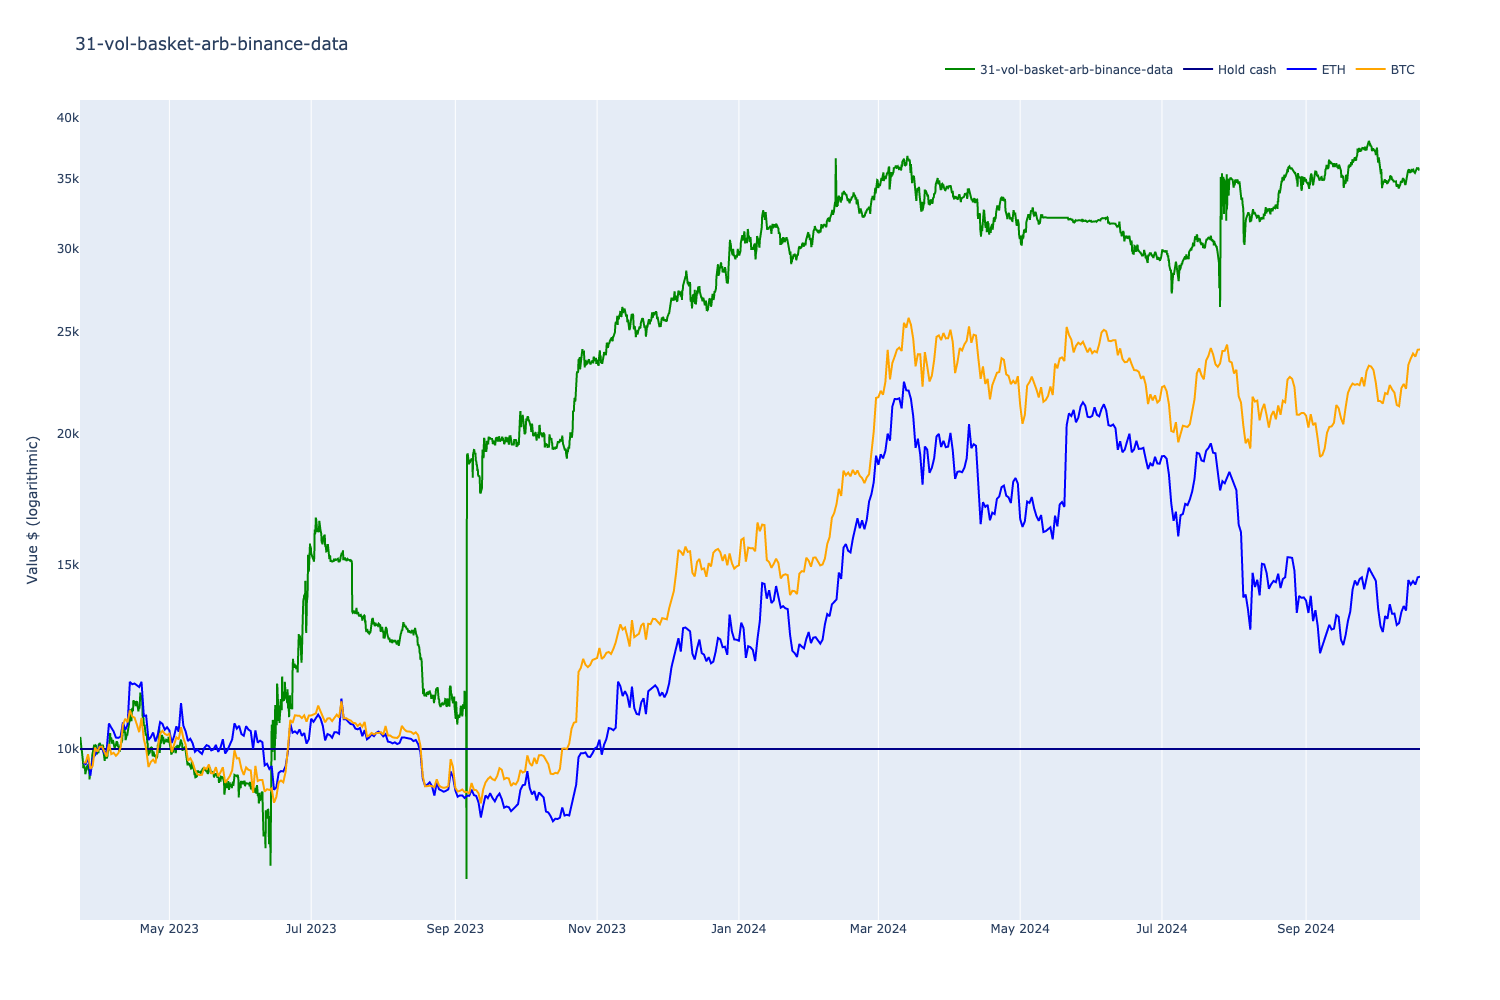

In [38]:
import pandas as pd
from tradeexecutor.analysis.multi_asset_benchmark import get_benchmark_data
from tradeexecutor.visual.benchmark import visualise_equity_curve_benchmark

benchmark_indexes = get_benchmark_data(
    strategy_universe,
    cumulative_with_initial_cash=state.portfolio.get_initial_cash(),
    max_count=4,
    start_at=state.get_trading_time_range()[0],
    interesting_assets=["WETH", "WBTC"]
)

fig = visualise_equity_curve_benchmark(
    state=state,    
    benchmark_indexes=benchmark_indexes,
    height=800,
    log_y=True,
)

fig.show()

## Equity curve with drawdown

- Linear curve

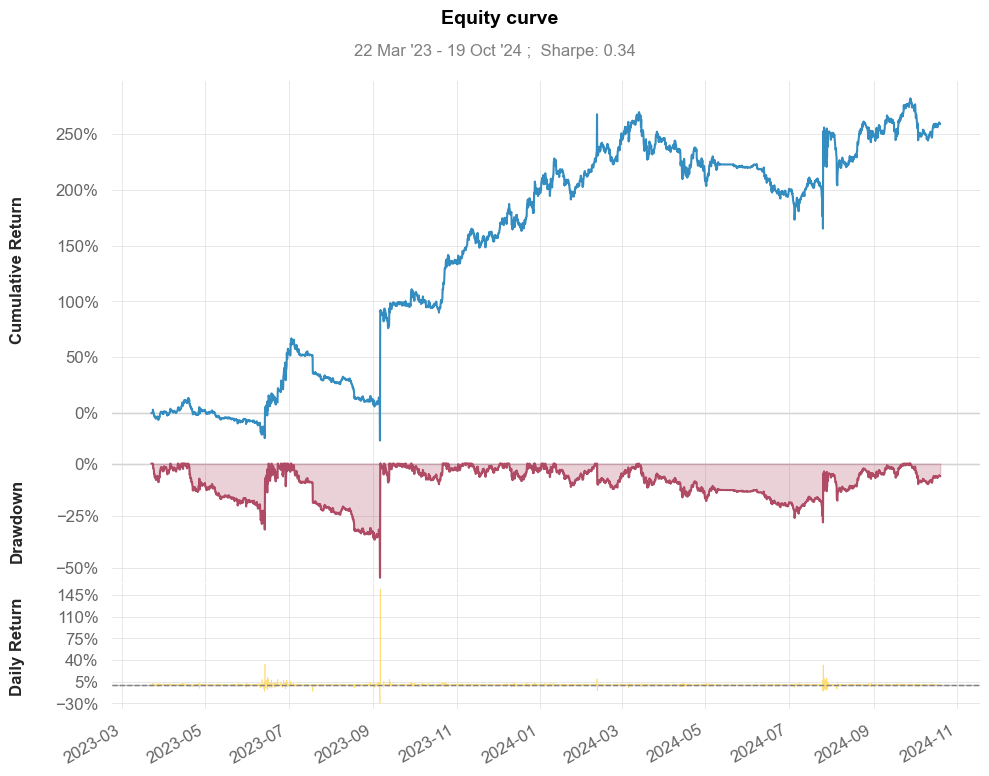

In [39]:
from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.visual.equity_curve import visualise_equity_curve

curve = calculate_equity_curve(state)
returns = calculate_returns(curve)
fig = visualise_equity_curve(returns)
display(fig)

# Available pairs

- Number of pairs available to trade every month



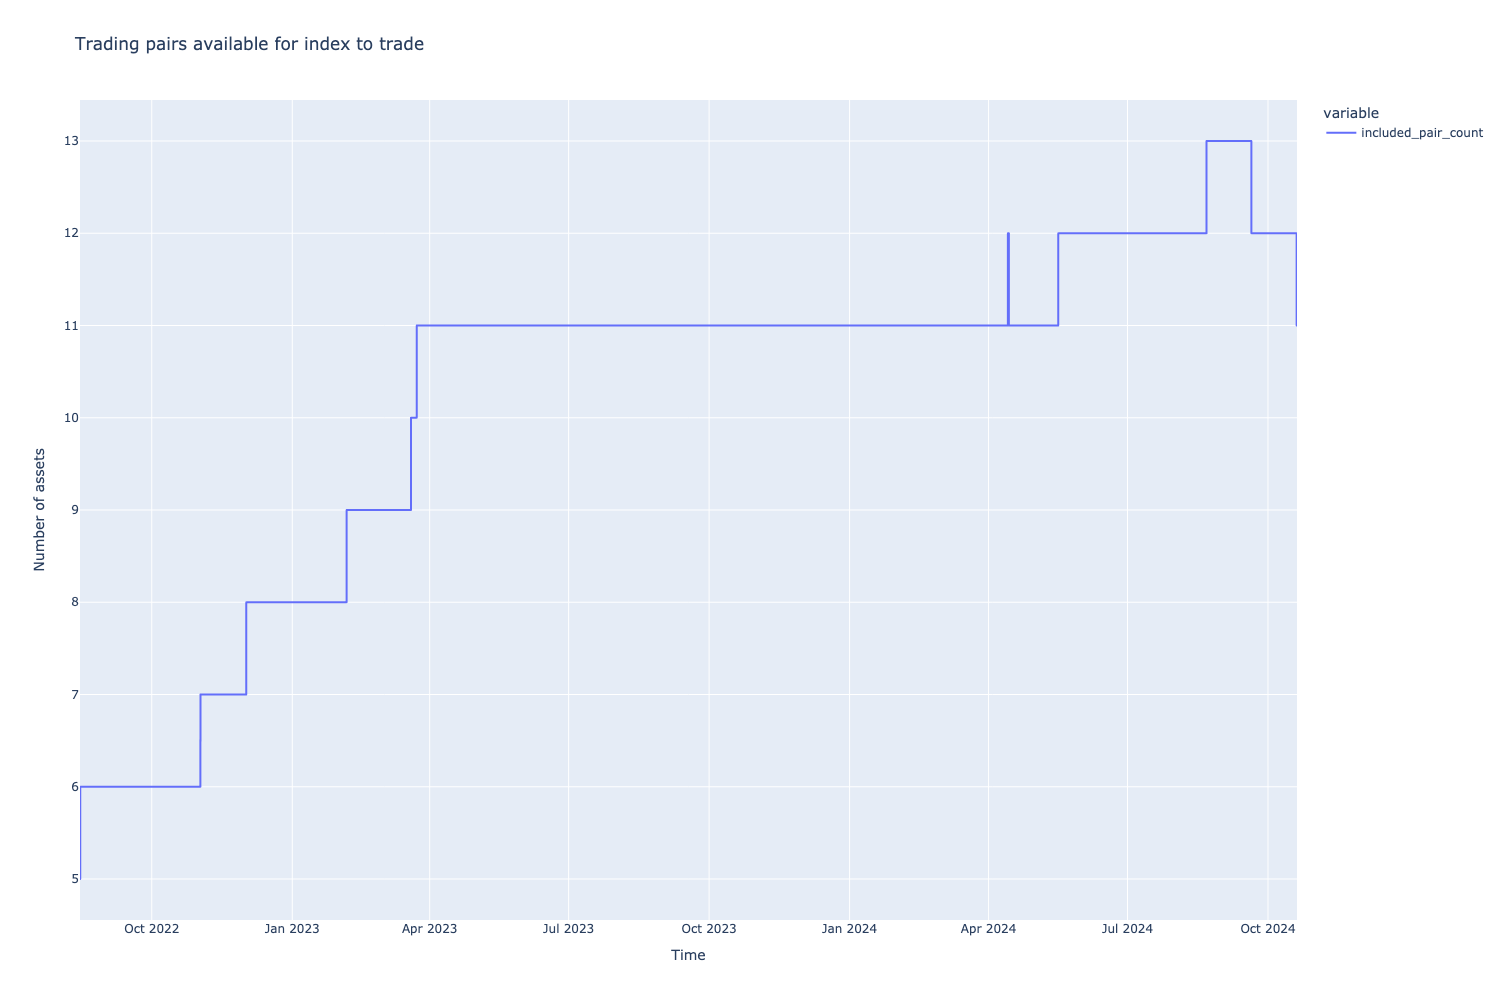

Available at the end WBTC WETH
Available at the end ARB WETH
Available at the end LINK WETH
Available at the end GMX WETH
Available at the end GRT WETH
Available at the end AAVE WETH
Available at the end CRV WETH
Available at the end UNI WETH
Available at the end RDNT WETH
Available at the end DLCBTC WETH
Available at the end COMP WETH
Available at the end BAL WETH


In [40]:
import plotly.express as px

df = pd.DataFrame({
    "included_pair_count": indicators.get_indicator_series("included_pair_count")
})

fig = px.line(df, title='Trading pairs available for index to trade')
fig.update_yaxes(title="Number of assets")
fig.update_xaxes(title="Time")
fig.show()

# Pairs in in end 
df = indicators.get_indicator_series("volume_inclusion_criteria")
last_at = df.index[-40]
pair_ids = df.loc[last_at]

for pair_id in pair_ids:
    pair = strategy_universe.get_pair_by_id(pair_id)
    print("Available at the end", pair.base.token_symbol, pair.quote.token_symbol)

# Price data and anomalies

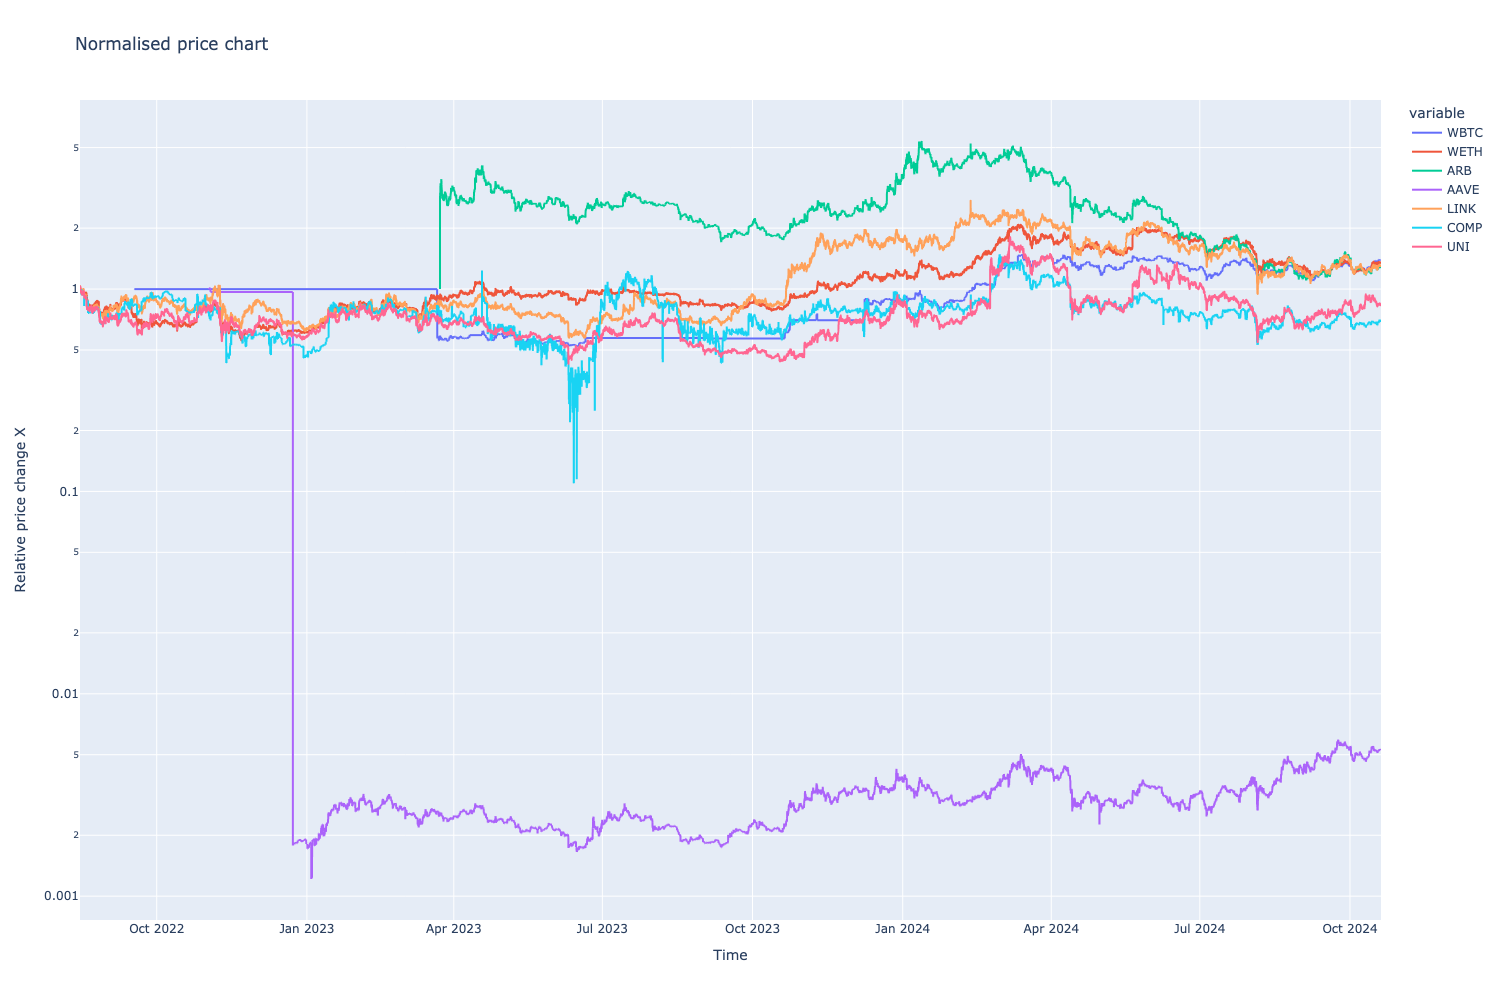

In [51]:
# selected_assets = ["WBTC", "WETH", "ARB", "AAVE", "LINK"]

selected_assets = ["WBTC", "WETH", "ARB", "AAVE", "LINK", "COMP", "UNI"]

# Plot prices
import plotly.express as px
data = {}
for symbol in selected_assets:
    pair = token_map[symbol]
    candles = strategy_universe.data_universe.candles.get_candles_by_pair(pair.internal_id)
    assert candles is not None, f"No candles found for asset {symbol}, we have token map for {list(token_map.keys())}, pair is #{pair.internal_id}, {pair}"
    price = candles["close"]
    first_price = price.iloc[0]
    data[symbol] = price / first_price
        

df = pd.DataFrame(data)
fig = px.line(df, title=f"Normalised price chart")
fig.update_layout(showlegend=True)
fig.update_yaxes(title=f"Relative price change X", type="log")
fig.update_xaxes(title="Time")
fig.show()


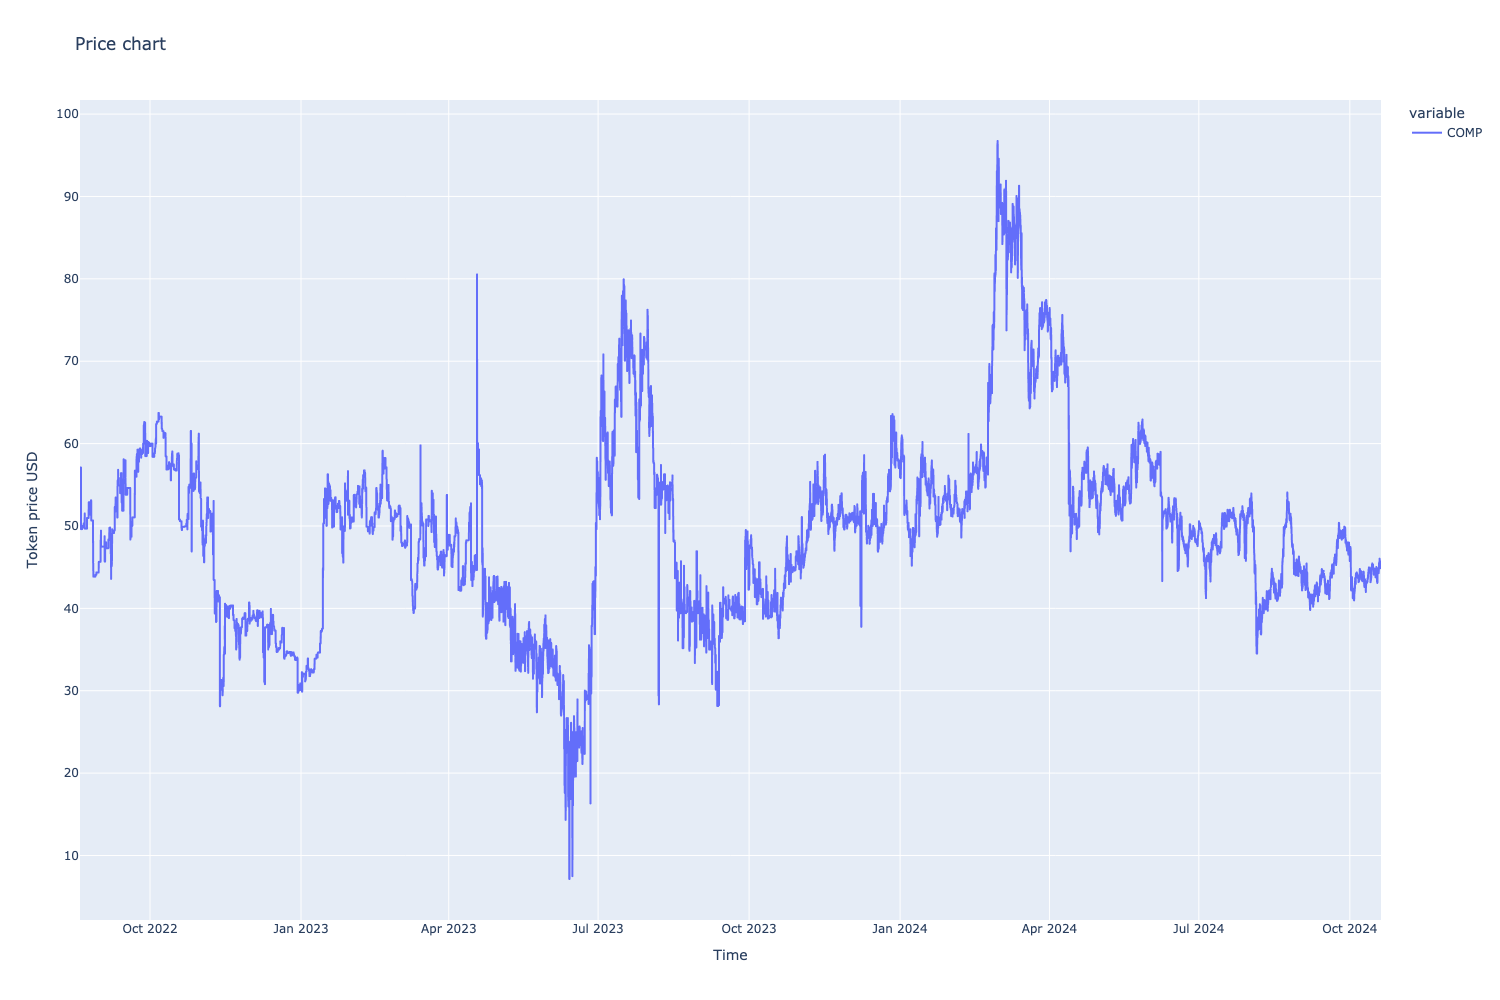

COMP
timestamp                     
2023-08-06 00:00:00  56.125606
2023-08-06 01:00:00  56.125606
2023-08-06 02:00:00  56.125606
2023-08-06 03:00:00  56.125606
2023-08-06 04:00:00  55.641686
2023-08-06 05:00:00  55.641686
2023-08-06 06:00:00  55.641686
2023-08-06 07:00:00  55.641686
2023-08-06 08:00:00  55.641686
2023-08-06 09:00:00  55.641686
2023-08-06 10:00:00  55.641686
2023-08-06 11:00:00  55.784366
2023-08-06 12:00:00  55.784366
2023-08-06 13:00:00  54.918975
2023-08-06 14:00:00  54.918975
2023-08-06 15:00:00  54.059976
2023-08-06 16:00:00  54.059976
2023-08-06 17:00:00  54.567879
2023-08-06 18:00:00  54.940253
2023-08-06 19:00:00  54.875021
2023-08-06 20:00:00  29.421042
2023-08-06 21:00:00  29.421042
2023-08-06 22:00:00  29.421042
2023-08-06 23:00:00  29.421042
2023-08-07 00:00:00  32.323089
2023-08-07 01:00:00  28.344940
2023-08-07 02:00:00  49.560987
2023-08-07 03:00:00  54.101923
2023-08-07 04:00:00  55.242087
2023-08-07 05:00:00  55.242087
2023-08-07 06:00:00  55.242087
2023-08-07 07:00:00  55.242087
2023-08-07 08:00:00  55.242087
2023-08-07 09:00:00  55.254270
2023-08-07 10:00:00  55.047738
2023-08-07 11:00:00  55.047738
2023-08-07 12:00:00  55.086861
2023-08-07 13:00:00  54.904305
2023-08-07 14:00:00  54.904305
2023-08-07 15:00:00  54.904305
2023-08-07 16:00:00  53.182163
2023-08-07 17:00:00  53.182163
2023-08-07 18:00:00  53.434346
2023-08-07 19:00:00  53.434346
2023-08-07 20:00:00  52.588462
2023-08-07 21:00:00  52.588462
2023-08-07 22:00:00  52.588462
2023-08-07 23:00:00  52.588462

In [42]:
# https://www.coingecko.com/en/coins/compound
# https://www.geckoterminal.com/arbitrum/pools/0xdfa19e743421c394d904f5a113121c2227d2364b
# Bump on 2013-08-06 confirmed with GeckoTerminal
fixed_price_assets = ["COMP"]

data = {}

for symbol in fixed_price_assets:
    pair = token_map[symbol]
    candles = strategy_universe.data_universe.candles.get_candles_by_pair(pair.internal_id)
    candles = candles.iloc[100:]  # Chop off low liq start
    assert candles is not None, f"No candles found for asset {symbol}, we have token map for {list(token_map.keys())}, pair is #{pair.internal_id}, {pair}"
    price = candles["close"]
    data[symbol] = price

df = pd.DataFrame(data)
fig = px.line(df, title=f"Price chart")
fig.update_layout(showlegend=True)
fig.update_yaxes(title=f"Token price USD")
fig.update_xaxes(title="Time")
fig.show()


display(df["2023-08-06":"2023-08-07"])

        

# Indicator data



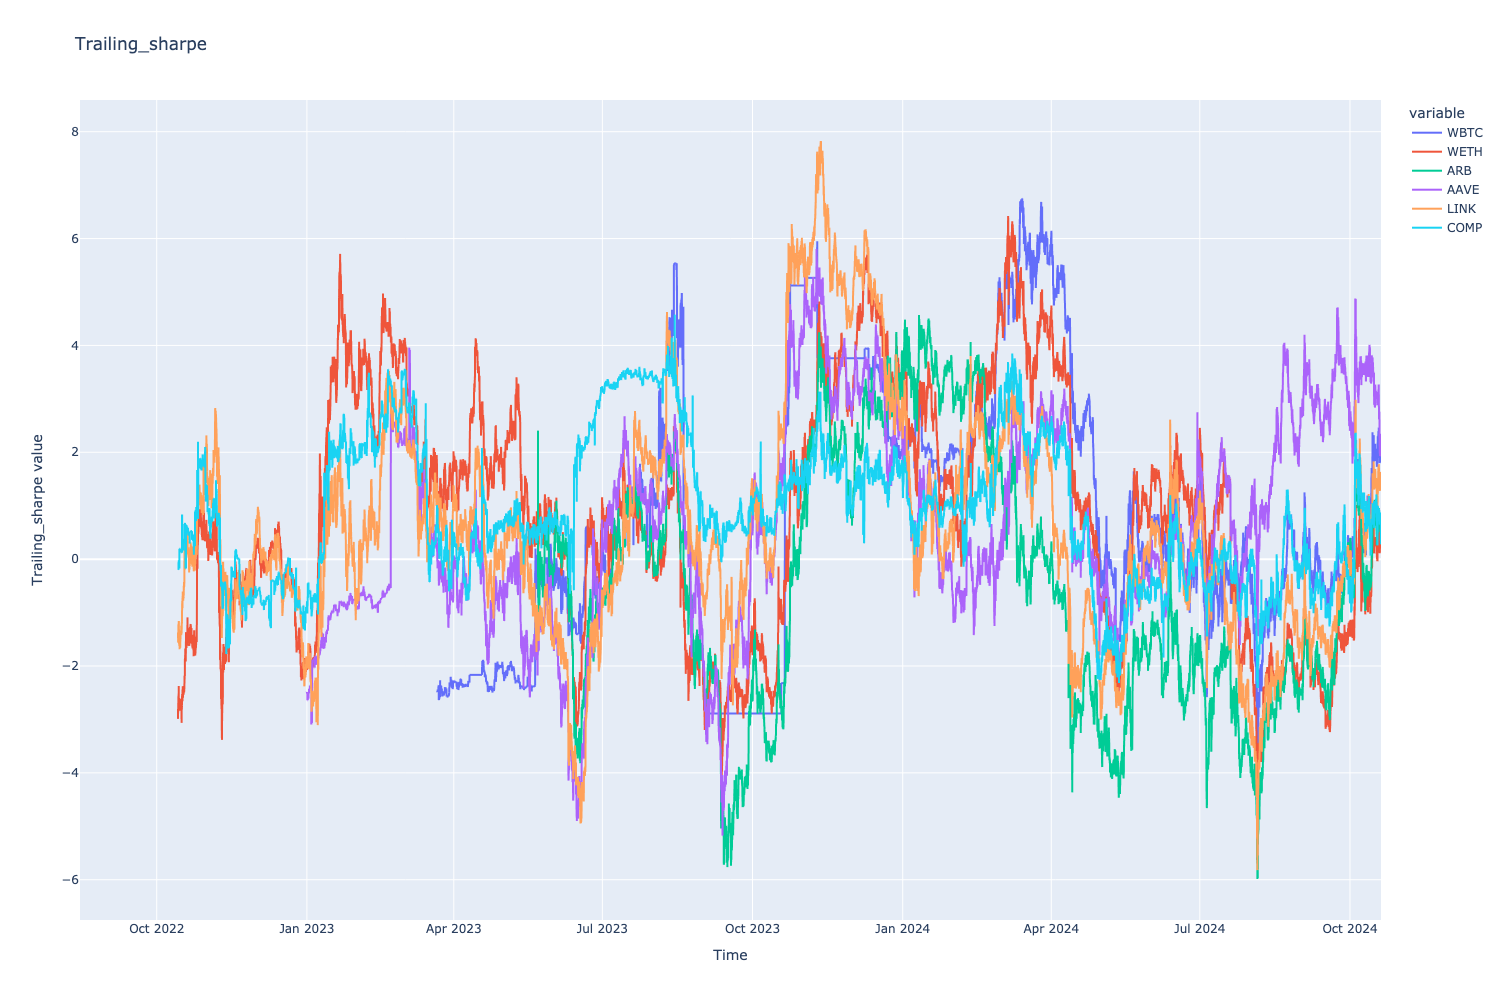

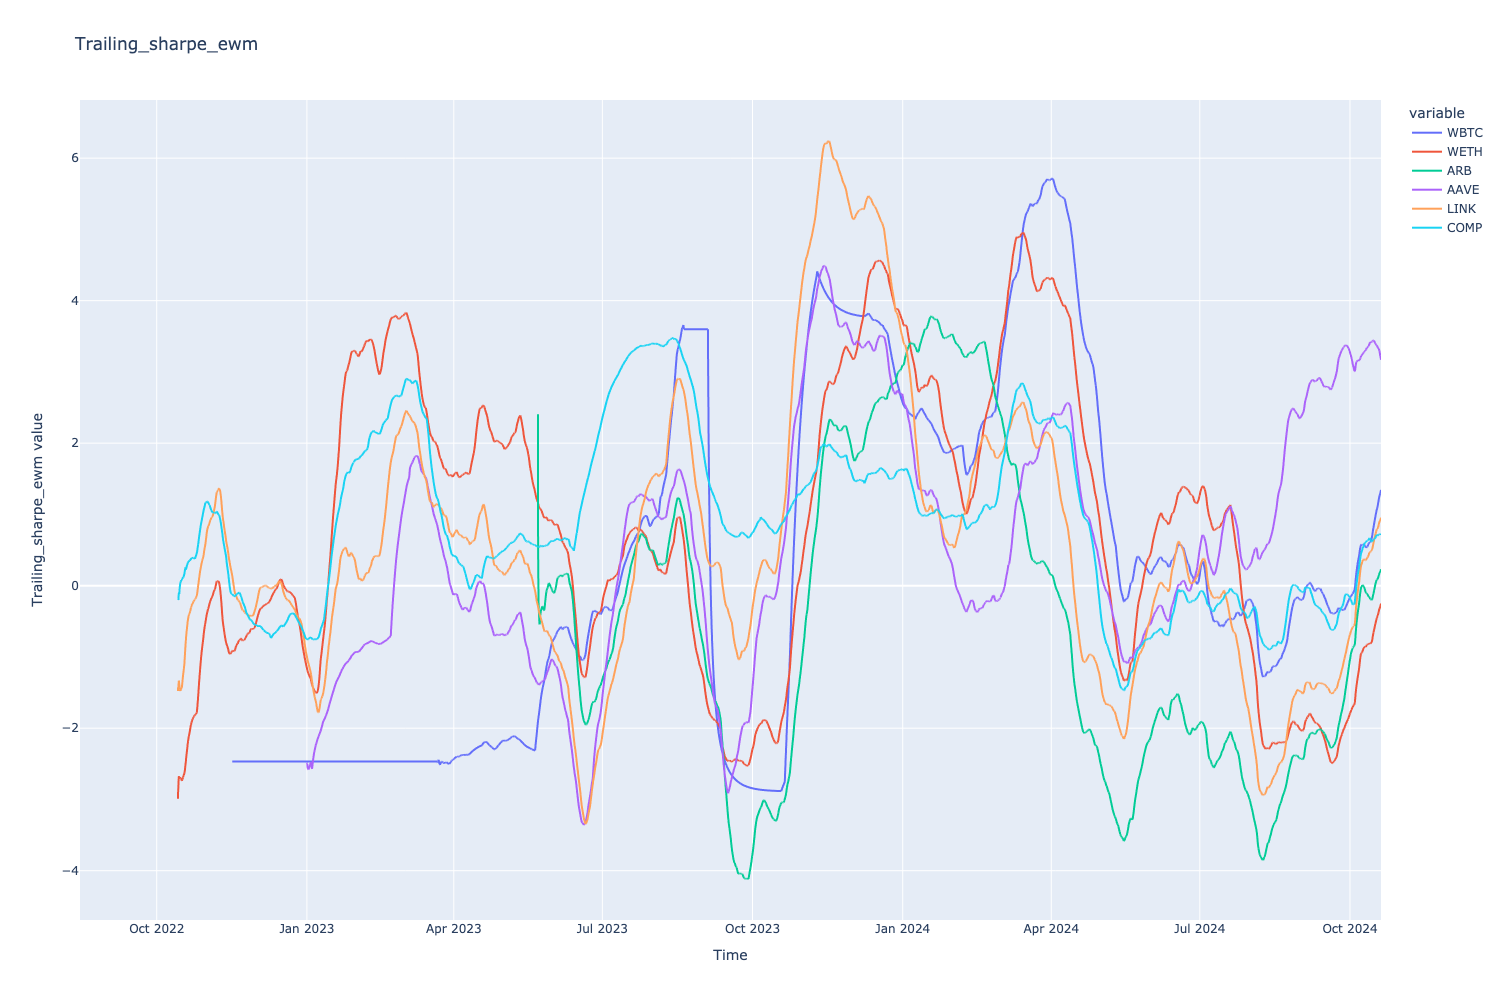

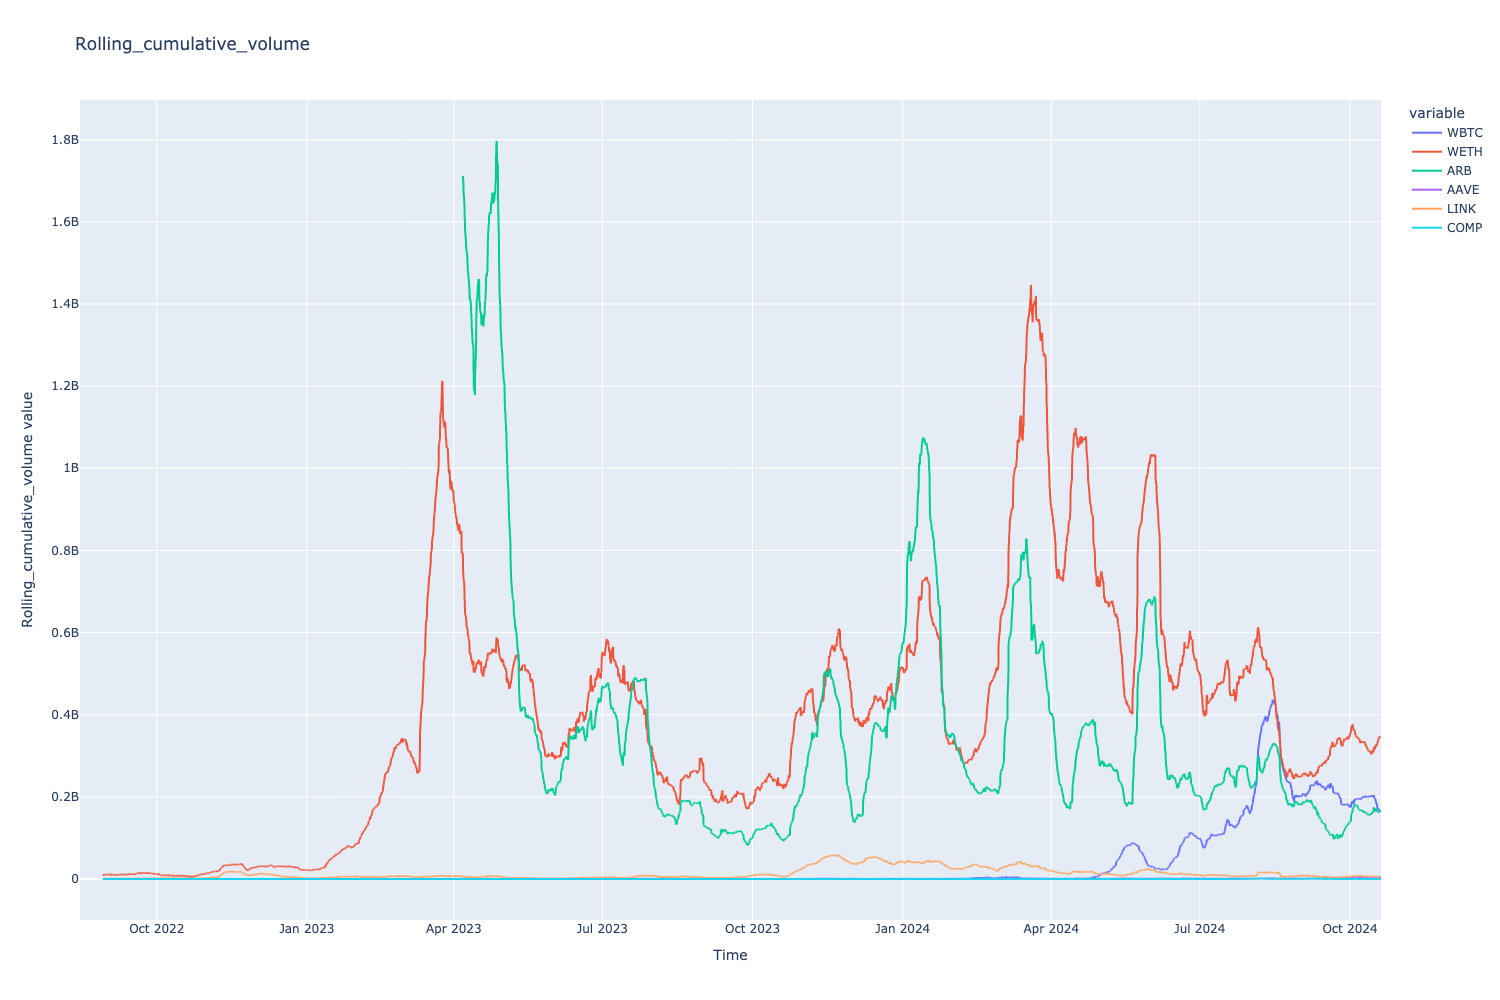

In [43]:
# Plot example indicators

import plotly.express as px

checked_indicators = [
    #"volatility", 
    "trailing_sharpe", 
    "trailing_sharpe_ewm", 
    "rolling_cumulative_volume",
]

for indicator_name in checked_indicators:

    data = {}
    for symbol in selected_assets:
        pair = token_map[symbol]
        data[symbol] = series = indicators.get_indicator_series(indicator_name, pair=pair)

        if series is None or len(series) == 0:
            print(f"Asset {symbol} has no data for {indicator_name}")

    df = pd.DataFrame(data)
    fig = px.line(df, title=f"{indicator_name.capitalize()}")
    fig.update_layout(showlegend=True)
    fig.update_yaxes(title=f"{indicator_name.capitalize()} value")
    fig.update_xaxes(title="Time")
    fig.show()

# Asset weights

- What assets were allocated over time
- Do both proportional % and USD weights

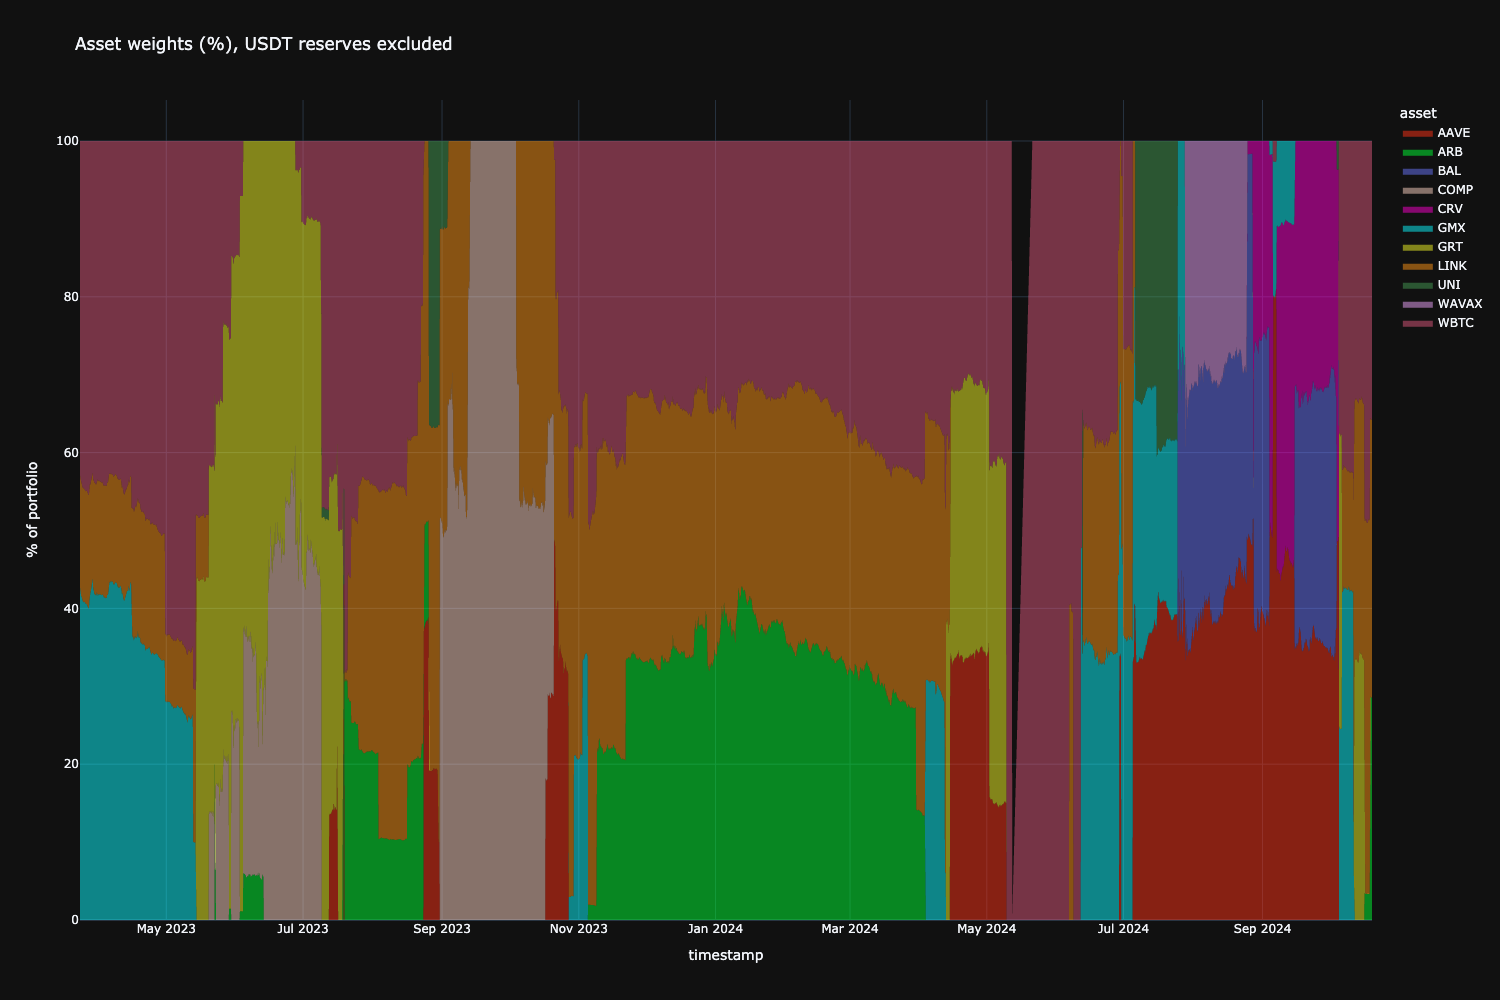

In [44]:
from tradeexecutor.analysis.weights import calculate_asset_weights, visualise_weights

weights_series = calculate_asset_weights(state)

fig = visualise_weights(
    weights_series,
    normalised=True,
    include_reserves=False,
)
fig.show()

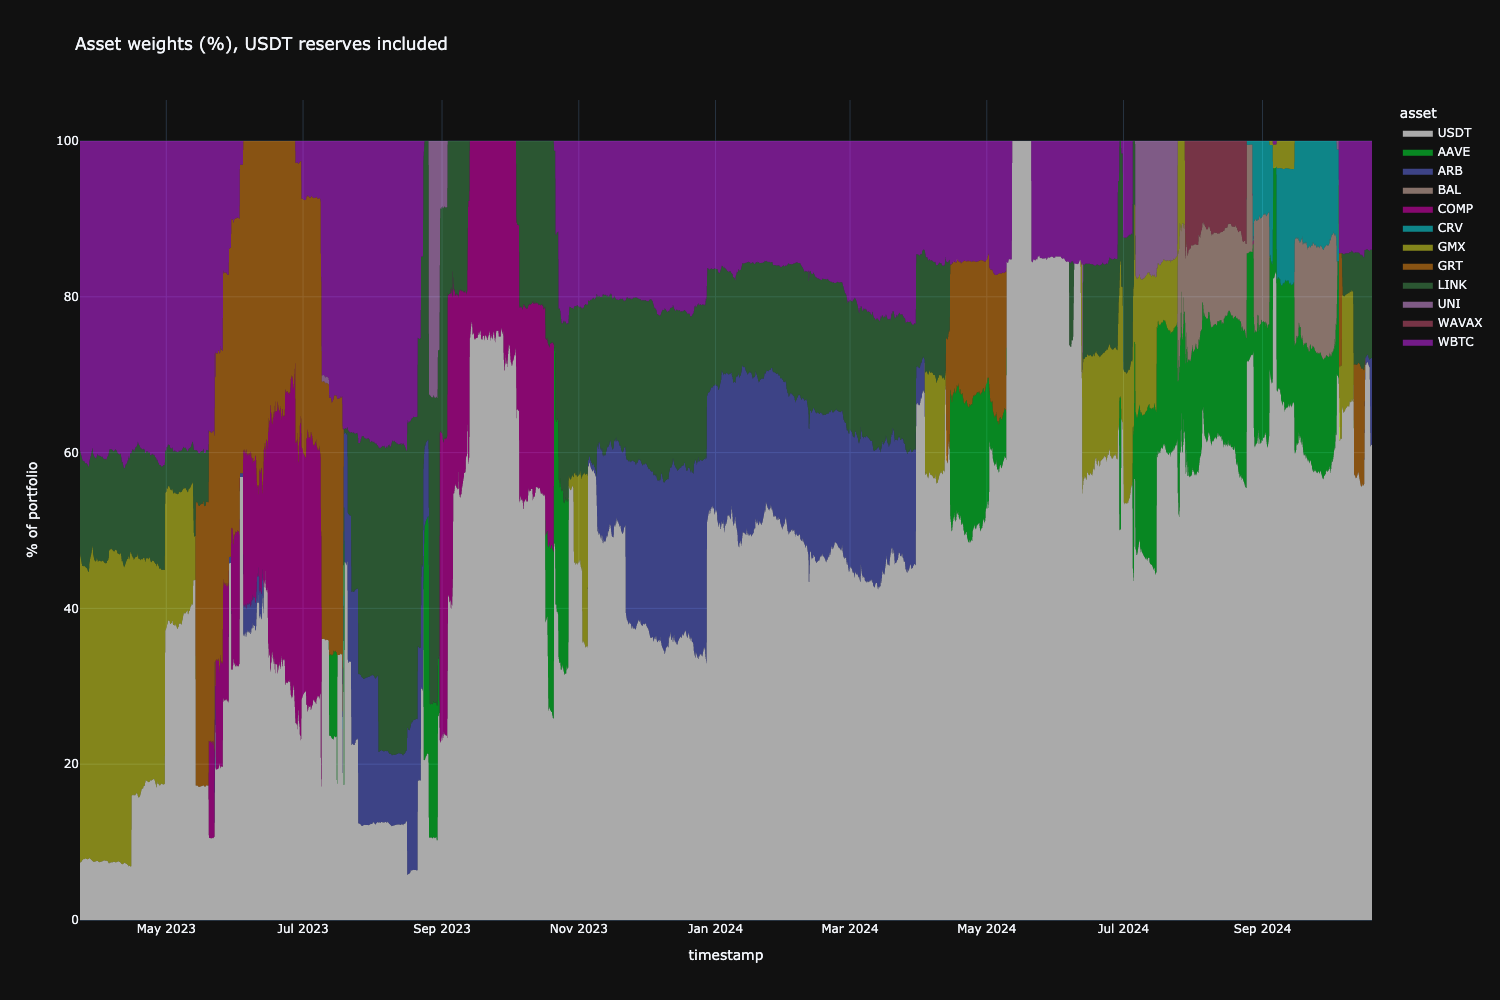

In [45]:

fig = visualise_weights(
    weights_series,
    normalised=True,
    include_reserves=True,
)
fig.show()

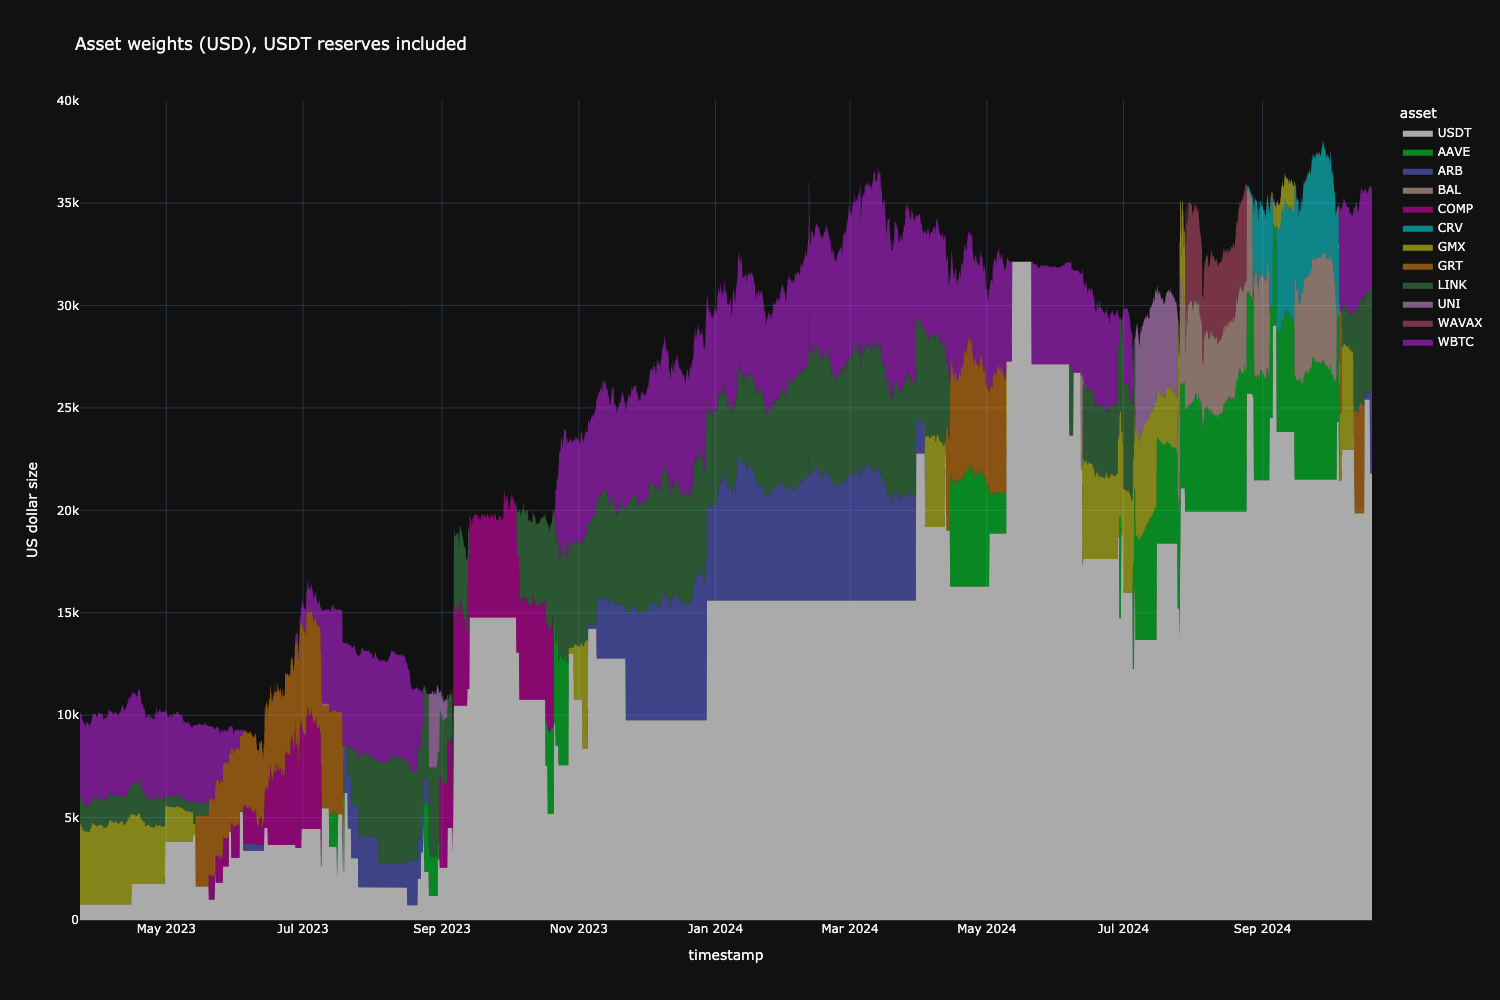

In [46]:
df = weights_series.unstack(level=1)

fig = visualise_weights(
    weights_series,
    normalised=False,
)
fig.show()

## Weight allocation statistics



In [47]:
from tradeexecutor.analysis.weights import calculate_weights_statistics

stats = calculate_weights_statistics(weights_series)
display(stats)


At  Pair     Value Unit
Name                                                                    
Max position (excluding USDT)   2024-03-14 04:00:00  WBTC  8,434.35  USD
Min position (excluding USDT)   2023-06-03 20:00:00   ARB     43.77  USD
Mean position (excluding USDT)                             4,337.68  USD
Max position (excluding USDT)   2023-09-13 08:00:00  COMP    100.00    %
Min position (excluding USDT)   2023-05-22 20:00:00   ARB      1.01    %
Mean position (excluding USDT)                                36.06    %
Max position (including USDT)   2024-05-12 08:00:00  USDT    100.00    %
Min position (including USDT)   2024-08-28 00:00:00  COMP      0.44    %
Mean position (including USDT)                                26.80    %

# Trades

- Examine individual trades


In [69]:
data = [
    {
        "timestamp": t.executed_at,
        "value": t.get_value(),
        "pair": t.pair.get_ticker(),
        "direction": "buy" if t.is_buy() else "sell",
        "price": t.executed_price,
    } for t in state.portfolio.get_all_trades()
]

df = pd.DataFrame(data)
df = df.set_index("timestamp", drop=False)

df_sample = df.loc[(df["timestamp"] > "2023-08-06") & (df["timestamp"] < "2023-09-10")]
display(df_sample)

timestamp        value       pair direction  \
timestamp                                                                   
2023-08-16 12:00:00 2023-08-16 12:00:00   512.275654  WBTC-WETH      sell   
2023-08-21 04:00:00 2023-08-21 04:00:00  1144.748380  WBTC-WETH      sell   
2023-08-22 16:00:00 2023-08-22 16:00:00  1189.036249  WBTC-WETH      sell   
2023-08-23 16:00:00 2023-08-23 16:00:00  1383.373058  WBTC-WETH      sell   
2023-08-23 20:00:00 2023-08-23 20:00:00   290.837500  WBTC-WETH      sell   
2023-08-16 12:00:00 2023-08-16 12:00:00  1238.600716   ARB-WETH       buy   
2023-08-21 04:00:00 2023-08-21 04:00:00   221.907603   ARB-WETH      sell   
2023-08-22 16:00:00 2023-08-22 16:00:00   107.480269   ARB-WETH      sell   
2023-08-23 16:00:00 2023-08-23 16:00:00   162.559999   ARB-WETH      sell   
2023-08-23 20:00:00 2023-08-23 20:00:00   509.083829   ARB-WETH      sell   
2023-08-26 04:00:00 2023-08-26 04:00:00  1095.166209   ARB-WETH      sell   
2023-08-23 20:00:00 2023-08-23 20:00:00  3392.689610  AAVE-WETH       buy   
2023-08-26 04:00:00 2023-08-26 04:00:00  1472.704528  AAVE-WETH      sell   
2023-08-30 04:00:00 2023-08-30 04:00:00  1135.028354  AAVE-WETH      sell   
2023-08-31 00:00:00 2023-08-31 00:00:00   815.699973  AAVE-WETH      sell   
2023-08-26 04:00:00 2023-08-26 04:00:00  3619.149014   UNI-WETH       buy   
2023-08-30 04:00:00 2023-08-30 04:00:00   688.067506   UNI-WETH      sell   
2023-08-31 00:00:00 2023-08-31 00:00:00  1980.444881   UNI-WETH      sell   
2023-09-03 12:00:00 2023-09-03 12:00:00   929.776598   UNI-WETH      sell   
2023-08-16 12:00:00 2023-08-16 12:00:00   137.517550  LINK-WETH       buy   
2023-08-21 04:00:00 2023-08-21 04:00:00    76.692241  LINK-WETH       buy   
2023-08-23 16:00:00 2023-08-23 16:00:00    82.968525  LINK-WETH      sell   
2023-08-26 04:00:00 2023-08-26 04:00:00   123.970892  LINK-WETH       buy   
2023-08-30 04:00:00 2023-08-30 04:00:00    39.880785  LINK-WETH       buy   
2023-08-31 00:00:00 2023-08-31 00:00:00  1192.009144  LINK-WETH      sell   
2023-09-03 12:00:00 2023-09-03 12:00:00  1089.262232  LINK-WETH      sell   
2023-09-05 20:00:00 2023-09-05 20:00:00   911.620870  LINK-WETH      sell   
2023-09-06 00:00:00 2023-09-06 00:00:00  2366.994500  LINK-WETH       buy   
2023-08-31 00:00:00 2023-08-31 00:00:00  4390.052608  COMP-WETH       buy   
2023-09-03 12:00:00 2023-09-03 12:00:00    81.560177  COMP-WETH       buy   
2023-09-05 20:00:00 2023-09-05 20:00:00  2110.036055  COMP-WETH       buy   
2023-09-06 00:00:00 2023-09-06 00:00:00  9535.769203  COMP-WETH      sell   

                            price  
timestamp                          
2023-08-16 12:00:00  29113.353424  
2023-08-21 04:00:00  26063.953741  
2023-08-22 16:00:00  25919.736215  
2023-08-23 16:00:00  26128.080021  
2023-08-23 20:00:00  26669.941625  
2023-08-16 12:00:00      1.101600  
2023-08-21 04:00:00      1.020932  
2023-08-22 16:00:00      0.977046  
2023-08-23 16:00:00      0.999011  
2023-08-23 20:00:00      1.017651  
2023-08-26 04:00:00      0.952440  
2023-08-23 20:00:00     57.223233  
2023-08-26 04:00:00     56.893565  
2023-08-30 04:00:00     58.966312  
2023-08-31 00:00:00     57.627671  
2023-08-26 04:00:00      4.595037  
2023-08-30 04:00:00      4.737152  
2023-08-31 00:00:00      4.586565  
2023-09-03 12:00:00      4.415323  
2023-08-16 12:00:00      6.999731  
2023-08-21 04:00:00      6.228237  
2023-08-23 16:00:00      6.339271  
2023-08-26 04:00:00      6.032708  
2023-08-30 04:00:00      6.106280  
2023-08-31 00:00:00      5.919873  
2023-09-03 12:00:00      6.009621  
2023-09-05 20:00:00      6.098627  
2023-09-06 00:00:00      6.162259  
2023-08-31 00:00:00     40.052383  
2023-09-03 12:00:00     39.126870  
2023-09-05 20:00:00      7.852496  
2023-09-06 00:00:00     38.287107

# Trading pair breakdown

- Trade success for each trading pair



In [48]:
from tradeexecutor.analysis.multipair import analyse_multipair
from tradeexecutor.analysis.multipair import format_multipair_summary

multipair_summary = analyse_multipair(state)
format_multipair_summary(multipair_summary, sort_column="Total return %")

# Performance metrics

- Display portfolio performance metrics
- Compare against buy and hold matic using the same initial capital

**Note**: Some of these metrics might be incorrect due to slow start of the strategy

In [49]:
from tradeexecutor.analysis.multi_asset_benchmark import compare_strategy_backtest_to_multiple_assets

compare_strategy_backtest_to_multiple_assets(
    state,
    strategy_universe,
    display=True,
)

/Users/moo/code/trade-executor/tradeexecutor/analysis/multi_asset_benchmark.py:345: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



Strategy                  BTC  \
Start Period                      2023-03-23           2023-03-23   
End Period                        2024-10-19           2024-10-19   
Risk-Free Rate                          0.0%                 0.0%   
Time in Market                         99.0%               100.0%   
Cumulative Return                    258.66%              140.49%   
CAGR﹪                                 74.85%                46.8%   
Sharpe                                  1.02                 1.43   
Prob. Sharpe Ratio                    98.78%               96.66%   
Sortino                                 3.69                 2.27   
Sortino/√2                              2.61                  1.6   
Omega                                   1.52                 1.53   
Max Drawdown                         -54.39%              -26.31%   
Longest DD Days                          182                  219   
Gain/Pain Ratio                         0.52                 0.24   
Gain/Pain (1M)                          3.22                 2.38   
Payoff Ratio                            1.39                 1.24   
Profit Factor                           1.52                 1.24   
Common Sense Ratio                      1.57                 1.39   
CPC Index                                1.1                 0.79   
Tail Ratio                              1.03                 1.13   
Outlier Win Ratio                       4.55                 4.47   
Outlier Loss Ratio                      3.65                 3.62   
MTD                                   -3.79%                 4.6%   
3M                                     18.7%                5.81%   
6M                                    12.81%               11.55%   
YTD                                   19.84%               60.99%   
1Y                                    87.46%               140.1%   
3Y (ann.)                             74.85%                46.8%   
5Y (ann.)                             74.85%                46.8%   
10Y (ann.)                            74.85%                46.8%   
All-time (ann.)                       74.85%                46.8%   
Avg. Drawdown                         -6.46%               -5.21%   
Avg. Drawdown Days                        15                   20   
Recovery Factor                         3.85                 3.97   
Ulcer Index                             0.12                 0.11   
Serenity Index                          5.44                 1.14   
Annualised return (raw)             0.748532                  NaN   
Benchmark start          2023-03-23 13:00:00  2023-03-23 13:00:00   
Start price                                -             27439.71   
End price                                  -             68118.98   
Price diff                                 -                 1.48   
Multiplier X                               -                 2.48   
Candle freq                                -      0 days 01:00:00   

                                         ETH                  ARB  
Start Period                      2023-03-23           2023-03-23  
End Period                        2024-10-19           2024-10-19  
Risk-Free Rate                          0.0%                 0.0%  
Time in Market                        100.0%               100.0%  
Cumulative Return                     45.83%              -59.05%  
CAGR﹪                                 17.95%              -32.34%  
Sharpe                                  0.71                -0.22  
Prob. Sharpe Ratio                    81.54%               39.15%  
Sortino                                 1.09                -0.33  
Sortino/√2                              0.77                -0.24  
Omega                                   1.53                 1.53  
Max Drawdown                         -44.94%              -79.49%  
Longest DD Days                          221                  282  
Gain/Pain Ratio                         0.11   

# Trading metrics

- Trading cost, etc.

In [50]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)
summary = analysis.calculate_summary_statistics()
display(summary.to_dataframe())